In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import division
import pandas as pd
import numpy as np
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from scipy import optimize
import time
import seaborn as sns
import ML_functions as mlf
from sklearn.metrics import recall_score

#Referenced and modified Rayid's magic loop 
#Magic loop https://github.com/rayidghani/magicloops 
#Used stackoverflow for guidance on visualizations and dataframe operations


/Users/saptarshighose/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/saptarshighose/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Read in csvs as dataframes

In [2]:
full_projects_df = mlf.read_data('/Users/saptarshighose/Downloads/projects.csv', file_type = 'csv')
full_outcomes_df = mlf.read_data('/Users/saptarshighose/Downloads/outcomes.csv', file_type = 'csv')

# Pre-process dataframes

In [3]:
mlf.pre_process(full_projects_df)

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached
count,6.213620e+05,664098.000000,664098.000000,664094.000000,629016.000000,6.640980e+05,6.640980e+05,663952.000000
mean,2.608577e+11,37.240948,-93.344760,52926.452644,27.495822,5.420415e+02,6.447128e+02,97.233547
std,1.589754e+11,4.668155,17.761908,31193.738658,8.663046,1.267738e+04,1.545863e+04,2283.327661
min,1.000050e+10,18.249140,-176.634989,410.000000,9.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.000230e+11,34.038082,-112.003213,27589.000000,17.000000,2.672000e+02,3.175000e+02,22.000000
50%,2.615730e+11,37.662476,-87.681219,50702.000000,30.000000,4.110000e+02,4.878400e+02,30.000000
75%,3.704720e+11,40.758827,-79.193091,85043.000000,35.000000,5.864900e+02,6.963875e+02,100.000000
max,6.100009e+11,67.258157,-66.628036,99950.000000,35.000000,1.025002e+07,1.250002e+07,999999.000000


In [4]:
mlf.pre_process(full_outcomes_df)

,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
count,439487.00000,524928.000000,524928.000000
mean,52.92709,0.777339,4.361290
std,35.71410,2.227933,5.668748
min,0.00000,0.000000,0.000000
25%,25.00000,0.000000,1.000000
50%,50.00000,0.000000,3.000000
75%,83.00000,0.000000,5.000000
max,100.00000,151.000000,304.000000


# Filter and Merge relevant data and columns

In [5]:
projects_df = mlf.filter_df_by_date_range(full_projects_df, 'date_posted', '2011-01-01', '2013-12-31')
proj_out_df = pd.merge(projects_df, full_outcomes_df, on='projectid')

In [6]:
proj_out_df.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'is_exciting', 'at_least_1_teacher_referred_donor',
       'fully_funded', 'at_least_1_green_donation', 'great_chat',
       'three_or_more_non_teacher_re

In [7]:
relevant_df = proj_out_df[['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted','fully_funded']]

# Convert t/f to 1/0

In [8]:
mlf.convert_true_false_1_0(relevant_df)

/Users/saptarshighose/Downloads/Machine-Learning/HW3/ML_functions.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].apply(lambda x: 1 if x=='t' else 0)


In [9]:
relevant_df.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded
0,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,...,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,0,0,2013-12-31,1
1,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,...,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,0,0,2013-12-31,0
2,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,...,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,0,0,2013-12-31,0
3,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,...,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,0,0,2013-12-31,0
4,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,...,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,1,0,2013-12-31,1


In [10]:
mlf.pre_process(relevant_df)

,school_ncesid,school_latitude,school_longitude,school_zip,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded
count,3.282930e+05,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353050.000000,353151.000000,353151.000000,353151.000000
mean,2.503127e+11,36.868563,-95.398318,56301.763713,0.094444,0.085057,0.049078,0.011788,0.006637,0.006116,0.049087,0.010211,32.220311,531.372372,625.143964,94.187169,0.317026,0.044279,0.701394
std,1.648173e+11,4.927417,18.118360,31043.523511,0.292446,0.278967,0.216032,0.107932,0.081199,0.077968,0.216049,0.100532,2.484309,844.069364,993.022780,156.987405,0.465318,0.205713,0.457647
min,1.000050e+10,18.249140,-171.690554,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,37.030000,43.560000,1.000000,0.000000,0.000000,0.000000
25%,6.372301e+10,33.916387,-117.246823,29388.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,288.750000,339.710000,23.000000,0.000000,0.000000,0.000000
50%,2.400090e+11,36.675826,-89.886438,60613.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,427.270000,502.670000,31.000000,0.000000,0.000000,1.000000
75%,3.904440e+11,40.680488,-80.761902,90007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,606.720000,713.790000,100.000000,1.000000,0.000000,1.000000
max,6.100008e+11,67.258157,-66.628036,99926.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,139725.410000,164382.840000,12143.000000,1.000000,1.000000,1.000000


# Find missing values in dataframe

In [11]:
mlf.find_missing_values(proj_out_df)

secondary_focus_subject                           116086
secondary_focus_area                              116086
great_messages_proportion                          56259
non_teacher_referred_count                         46246
donation_from_thoughtful_donor                     46246
one_non_teacher_referred_donor_giving_100_plus     46246
three_or_more_non_teacher_referred_donors          46246
at_least_1_green_donation                          46246
at_least_1_teacher_referred_donor                  46246
teacher_referred_count                             46246
school_metro                                       43021
school_ncesid                                      24858
school_district                                      429
students_reached                                     101
resource_type                                         42
primary_focus_subject                                 35
primary_focus_area                                    35
grade_level                    

# Find binary categorical variables from dataframe

In [12]:
binary_categoricals = mlf.binary_categorical_vars(proj_out_df)
print(binary_categoricals)

['school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'fulfillment_labor_materials', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'is_exciting', 'fully_funded', 'great_chat']


# Find non-binary categorical variables from dataframe

In [13]:
non_binary_categoricals = mlf.non_binary_categorical_vars(proj_out_df, binary_categoricals)
print(non_binary_categoricals)

['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_state', 'school_zip', 'school_metro', 'school_district', 'school_county', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'date_posted', 'at_least_1_teacher_referred_donor', 'at_least_1_green_donation', 'three_or_more_non_teacher_referred_donors', 'one_non_teacher_referred_donor_giving_100_plus', 'donation_from_thoughtful_donor', 'great_messages_proportion', 'teacher_referred_count', 'non_teacher_referred_count']


# Create dataframe with only fully funded projects

In [14]:
fully_funded_df = mlf.filter_df_by_equality(relevant_df, 'fully_funded', 1)

# Explore fully_funded, grouped by other variables

In [15]:
relevant_df.groupby('grade_level')['fully_funded'].describe()

,count,mean,std,min,25%,50%,75%,max
grade_level,,,,,,,,
Grades 3-5,110181.0,0.694639,0.460562,0.0,0.0,1.0,1.0,1.0
Grades 6-8,60201.0,0.701550,0.457582,0.0,0.0,1.0,1.0,1.0
Grades 9-12,47765.0,0.705914,0.455635,0.0,0.0,1.0,1.0,1.0
Grades PreK-2,134998.0,0.705255,0.455930,0.0,0.0,1.0,1.0,1.0


In [16]:
relevant_df.groupby('poverty_level')['fully_funded'].describe()

,count,mean,std,min,25%,50%,75%,max
poverty_level,,,,,,,,
high poverty,96162.0,0.677357,0.467490,0.0,0.0,1.0,1.0,1.0
highest poverty,193518.0,0.721039,0.448490,0.0,0.0,1.0,1.0,1.0
low poverty,10065.0,0.695479,0.460227,0.0,0.0,1.0,1.0,1.0
moderate poverty,53406.0,0.674606,0.468526,0.0,0.0,1.0,1.0,1.0


In [17]:
relevant_df.groupby('primary_focus_area')['fully_funded'].describe()

,count,mean,std,min,25%,50%,75%,max
primary_focus_area,,,,,,,,
Applied Learning,23918.0,0.673677,0.468877,0.0,0.0,1.0,1.0,1.0
Health & Sports,9601.0,0.705968,0.455630,0.0,0.0,1.0,1.0,1.0
History & Civics,14412.0,0.699556,0.458467,0.0,0.0,1.0,1.0,1.0
Literacy & Language,161977.0,0.686332,0.463985,0.0,0.0,1.0,1.0,1.0
Math & Science,88266.0,0.722645,0.447696,0.0,0.0,1.0,1.0,1.0
Music & The Arts,31597.0,0.747318,0.434557,0.0,0.0,1.0,1.0,1.0
Special Needs,23345.0,0.691326,0.461956,0.0,0.0,1.0,1.0,1.0


# Visualize correlation heatmap and table

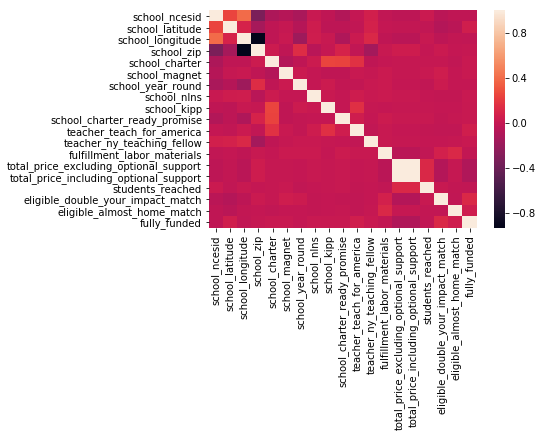

In [18]:
#Notes from heatmap: 
#Fully_funded is moderately positively correlated with whether the teacher was in TFA, the schools is a charter school,
#eligible for double your impact match, and whether the teach is a new york teaching fellow.
#Interestingly, fully_funded is also moderately negatively correlated with number of students reached and total price of 
#the project. 

mlf.visualize_correlation_heatmap(relevant_df)

In [19]:
corr = relevant_df.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,school_ncesid,school_latitude,school_longitude,school_zip,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded
school_ncesid,1,0.24,0.4,-0.33,-0.11,-0.069,-0.12,0.02,-0.022,-0.082,-0.00088,0.065,-0.018,-0.032,-0.032,0.027,-0.046,-0.026,-0.023
school_latitude,0.24,1,0.087,-0.14,-0.025,0.0072,-0.073,0.044,-0.03,-0.031,-0.017,0.08,0.00082,-0.012,-0.012,-0.015,-0.078,-0.045,0.055
school_longitude,0.4,0.087,1,-0.94,-0.023,0.022,-0.18,0.052,0.011,-0.1,0.029,0.12,-0.024,-0.047,-0.047,0.012,-0.031,-0.011,-0.018
school_zip,-0.33,-0.14,-0.94,1,0.038,-0.022,0.14,-0.057,0.005,0.087,-0.017,-0.15,0.01,0.041,0.041,-0.00011,0.031,0.0012,0.004
school_charter,-0.11,-0.025,-0.023,0.038,1,-0.079,-0.022,0.038,0.25,0.24,0.16,-0.024,-0.0032,0.0076,0.0076,0.0029,0.0038,-0.021,0.024
school_magnet,-0.069,0.0072,0.022,-0.022,-0.079,1,0.025,-0.0037,-0.024,-0.022,0.02,0.0086,0.025,0.0058,0.0058,0.023,0.047,-0.0056,0.017
school_year_round,-0.12,-0.073,-0.18,0.14,-0.022,0.025,1,-0.0049,0.034,-0.0077,-0.0096,0.017,0.027,-0.0011,-0.0011,-0.015,0.034,0.0011,-0.0025
school_nlns,0.02,0.044,0.052,-0.057,0.038,-0.0037,-0.0049,1,0.019,-0.0049,0.045,0.022,0.028,0.011,0.011,-0.00017,-0.013,-0.0096,0.018
school_kipp,-0.022,-0.03,0.011,0.005,0.25,-0.024,0.034,0.019,1,-0.0015,0.16,0.0052,-0.00083,0.0078,0.0078,0.0065,-0.0029,-0.0049,0.013
school_charter_ready_promise,-0.082,-0.031,-0.1,0.087,0.24,-0.022,-0.0077,-0.0049,-0.0015,1,0.053,-0.0062,0.038,0.0094,0.0094,0.015,-0.0066,0.0064,0.012


# Plot charts for data exploration

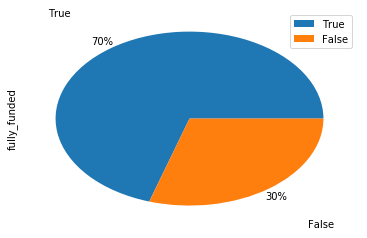

In [20]:
relevant_df.fully_funded.value_counts().plot(kind='pie',legend = True,labels=[True, False], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.5)

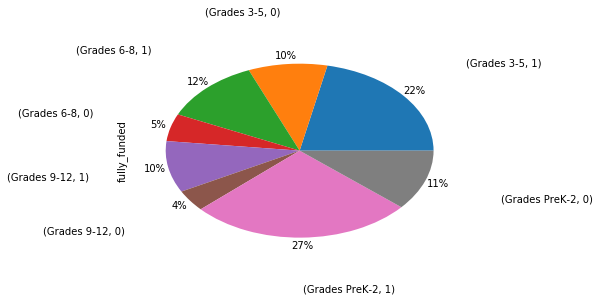

In [21]:
relevant_df.groupby('grade_level')['fully_funded'].value_counts().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.6)

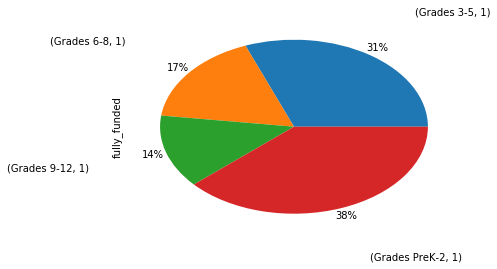

In [22]:
#Note: Grades preK-2 was the largest group of fully funded projects

fully_funded_df.groupby('grade_level')['fully_funded'].value_counts().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.6)

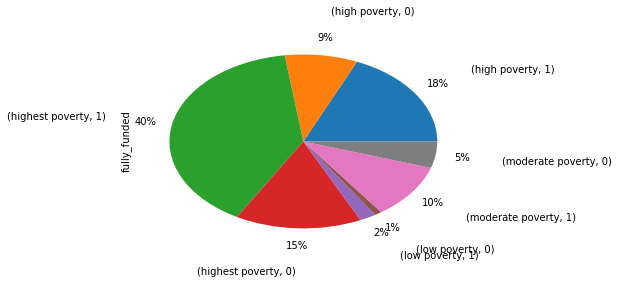

In [23]:
relevant_df.groupby('poverty_level')['fully_funded'].value_counts().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.5)

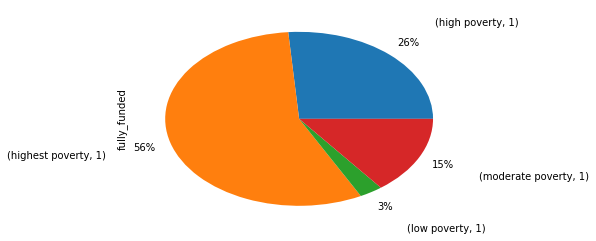

In [24]:
#Note: Highest poverty was the largest group of fully funded projects


fully_funded_df.groupby('poverty_level')['fully_funded'].value_counts().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.5)

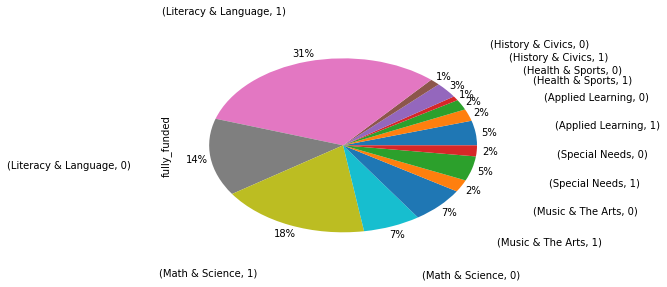

In [25]:
relevant_df.groupby('primary_focus_area')['fully_funded'].value_counts().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.6)

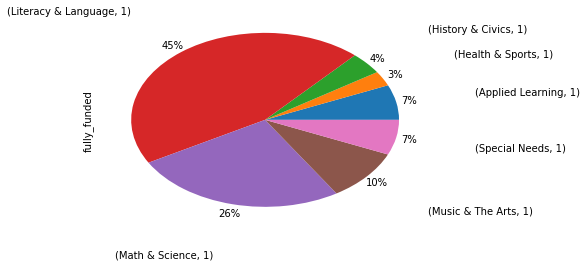

In [26]:
#Note: Literacy and language were the subjects most common to fully-funded projects.  


fully_funded_df.groupby('primary_focus_area')['fully_funded'].value_counts().plot(kind='pie', autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.6)

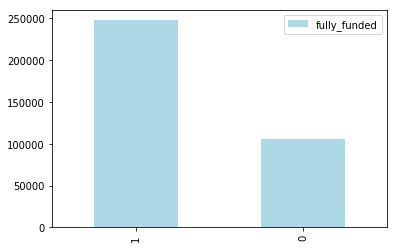

In [27]:
#Note: Most projects (roughly 70%) are fully funded

relevant_df.fully_funded.value_counts().plot.bar(color = 'lightblue', legend = True)

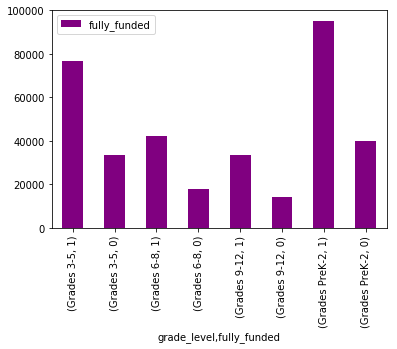

In [28]:
relevant_df.groupby('grade_level')['fully_funded'].value_counts().plot.bar(color = 'purple',legend = True)

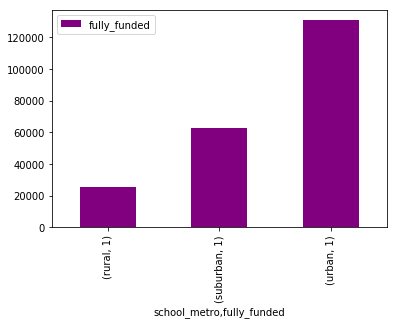

In [29]:
#Note: Most fully funded projects are in urban areas (also highest poverty) 

fully_funded_df.groupby('school_metro')['fully_funded'].value_counts().plot.bar(color = 'purple',legend = True)

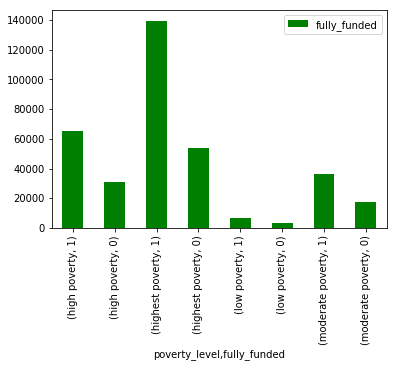

In [30]:
relevant_df.groupby('poverty_level')['fully_funded'].value_counts().plot.bar(color = 'green', legend = True)

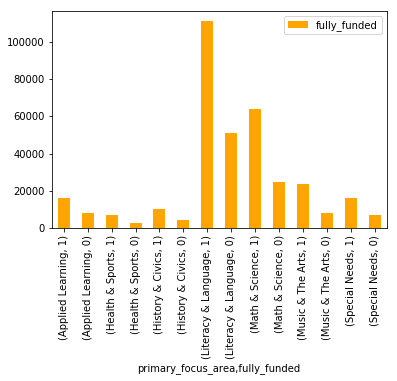

In [31]:
relevant_df.groupby('primary_focus_area')['fully_funded'].value_counts().plot.bar(color = 'orange',legend = True)